In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from datetime import datetime, timedelta

# 주식데이터 불러오기

### 종목코드와 링크 생성

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [3]:
#상장된 기업들목록에서 회사명과 종목코드만 가져옴
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2355 non-null   object
 1   code    2355 non-null   object
dtypes: object(2)
memory usage: 36.9+ KB


In [4]:
#회사명을 넣으면, code_df를 뒤져서 종목코드를 찾고, 네이버주식url에 덧대서 출력해주는 함수
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    code = code[1:7]
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url

item_name = '엔씨소프트'
url = get_url(item_name, code_df)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=036570


### 날짜별 종가, 전일비, 시가, 고가, 저가, 거래량 불러오기

In [5]:
def convert_col_name_kor_eng(df):  
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['date'], ascending=True) 
    df.head()
    return df

def get_dataset(num_date):
    df = pd.DataFrame()
    for page in range(1,num_date+1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df = df.dropna()
    df = convert_col_name_kor_eng(df)
    return df

df = get_dataset(493)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4928 entries, 7392 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4928 non-null   datetime64[ns]
 1   close   4928 non-null   int64         
 2   diff    4928 non-null   int64         
 3   open    4928 non-null   int64         
 4   high    4928 non-null   int64         
 5   low     4928 non-null   int64         
 6   volume  4928 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 308.0 KB


### 데이터프레임 -> 넘파이

In [7]:
df = df.drop(['date'], axis=1)
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4928 entries, 7392 to 1
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   4928 non-null   int64
 1   diff    4928 non-null   int64
 2   open    4928 non-null   int64
 3   high    4928 non-null   int64
 4   low     4928 non-null   int64
 5   volume  4928 non-null   int64
dtypes: int64(6)
memory usage: 269.5 KB


In [8]:
print(df_size)

4928


In [9]:
train_set = df[0:int(df_size*0.7)]
test_set = df[int(df_size*0.7):]

In [10]:
train = train_set.to_numpy()
test = test_set.to_numpy()

In [11]:
print(train.shape)
print(test.shape)
print(train[1])
print(train[2])

(3449, 6)
(1479, 6)
[87800  9400 87800 87800 87800   206]
[98300 10500 98300 98300 98300 92439]


# 데이터 전처리

#### minmax정규화, RNN용 shape으로 변경

In [12]:
def minmax_scaler(data):
    #print(np.min(data,0))
    numerator = data - np.min(data,0)
    #print(numerator.shape)
    denominator = np.max(data,0) - np.min(data,0)
    #print(numerator.shape)
    return numerator / (denominator + 1e-7)

def build_dataset(time_series, seq_length):
    train_size = int(len(time_series - seq_length))
    dataX = []
    dataY = []

    for i in range(0, len(time_series)-seq_length-1):
        _x = time_series[i:i + seq_length]
        _y = time_series[i + seq_length + 1,[0]]
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)
#2차원 배열 -> 넘파이배열로 변경시 자료의 사이즈가 맞지 않으면 object타입으로 처리해서 3차원배열로 인식하지 않는다.

In [13]:
train = minmax_scaler(train)
test_min = np.min(test, 0)
test_max = np.max(test, 0)
test_denom = test_max - test_min
test_minmax = (test-test_min) / (test_denom + 1e-7)#minmax_scaler(test) 

print(train_set.shape)
print(test_set.shape)

(3449, 6)
(1479, 6)


In [14]:
seq_length = 7

In [15]:
trainX, trainY = build_dataset(train, seq_length)
testX, testY = build_dataset(test_minmax, seq_length)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(3441, 7, 6) (3441, 1)
(1471, 7, 6) (1471, 1)


### 넘파이 -> 텐서

In [16]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [17]:
def load(batch_size):
    transform = None
    train_set = data_loader(trainX, trainY, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_set = data_loader(testX, testY, transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 0.학습 모델

In [19]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim)#, bias=True)
        )
    def forward(self, x):
        x, _status  = self.rnn(x)
        x = self.fc(x[:,-1])
        return x

def train_model():
    loss_arr = []
    for i in range(epoch):
        for j, [x, y] in enumerate(train_loader):
            train_x = x.to(device).float()
            train_y = y.to(device).float()
            optimizer.zero_grad()
            outputs = model.forward(train_x)

            #print(outputs.shape, train_y.shape)
            #print(outputs.dtype, train_y.dtype)

            loss = loss_func(outputs, train_y)
            #이걸 변수명을 같게하면 안되지!
            loss.backward()
            
            optimizer.step()
            loss_arr.append(loss)
       # print(i, loss)
    return loss_arr

# 1.모델 테스트

In [20]:
def test_model():
    testX_tensor = torch.FloatTensor(testX)
    testY_tensor = torch.FloatTensor(testY)
    loss_ar = []

    model.eval()
    with torch.no_grad():
        for j, [x, y] in enumerate(test_loader):
            #test_x = x.to(device).float()
            #test_y = y.to(device).float()
            test_x = testX_tensor.to(device).float()
            test_y = testY_tensor.to(device).float()
            predicted = model.forward(test_x)
            loss = loss_func(predicted, test_y)

            loss_ar.append(loss)
    return predicted, test_x, test_y

In [21]:
def reverse_minmax():
    predicted_y = predicted.cpu().numpy()
    test_y = testY
    test_x = test[7:,2]
    calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
    calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
    calculated_test_x = test_x.astype('int')
    return calculated_predicted_y, calculated_test_y, calculated_test_x

# 데이터 출력용 함수들

In [22]:
def show_train_status(): #학습한 loss 출력
    print('------------------------------------------------------------------------')
    print(model)
    #print(loss_func)
    #print(optimizer)
    print('----------------------')
    print('layers_num : ',layers)
    print('batch_size : ',batch_size)
    print('learning_r : ',lr)
    print('epoch_size : ',epoch)
    plt.plot(loss_arr)
    plt.show()

#### 1. 시가->예측종가기준으로 평가

In [23]:
def eval_open_to_predict_close(day):    
    day_length = len(calc_pred_y)
    money = 0
    count_acc = 0
    count_i = 0

    for i in range(day_length-day, day_length):
        count_i = count_i + 1
        #당일 날짜 계산
        today = datetime.today() - timedelta(days=day_length) + timedelta(days=i)
        str_year  = today.strftime('%Y')[:2]
        str_today = str_year + today.strftime('-%m-%d')
        # 투자하면 벌돈 및 실제 벌돈 계산
        expect_money = calc_pred_y[i] - calc_test_x[i]
        earn_money = calc_test_y[i] - calc_test_x[i]
        #print(str_today, '시작가\t','\t', '종가\t', '\t', '수익예상')
        #print('예상가\t', calculated_test_x[i],'\t', calculated_predicted_y[i], '\t',expect_money)
        #print('현실가\t', calculated_test_x[i],'\t', calculated_test_y[i], '\t', earn_money)
        # 수익예상이면 투자후 금액 출력
        if (expect_money > 0):
            money = money + earn_money
        #print('번돈\t', money)
        #print('-----------------------------------------------------')
        # 수익 예측을 정확이 했는지 판단.
        if (expect_money >0) & (earn_money >0): count_acc = count_acc + 1
        if (expect_money <0) & (earn_money <0): count_acc = count_acc + 1
    print('----------------------')
    print('시가->예측종가기준')
    print('벌어들인돈 : {0:d}원'.format(int(money)))
    print('정확도 : {0:.3f}%'.format(count_acc/count_i))

##### 2.전날예측종가->예측종가기준으로 평가

In [24]:
def eval_endPredict_to_predict_close(day):    
    day_length = len(calc_pred_y)
    money = 0
    count_acc = 0
    count_i = 0

    for i in range(day_length-day, day_length-1):
        count_i = count_i + 1
        #당일 날짜 계산
        today = datetime.today() - timedelta(days=day_length) + timedelta(days=i+1)
        str_year  = today.strftime('%Y')[:2]
        str_today = str_year + today.strftime('-%m-%d')
        # 투자하면 벌돈 및 실제 벌돈 계산
        expect_money = calc_pred_y[i+1] - calc_pred_y[i]
        earn_money = calc_test_y[i+1] - calc_test_y[i]
        #print(str_today, '시작가\t','\t', '종가\t', '\t', '수익예상')
        #print('예상가\t', calculated_predicted_y[i],'\t', calculated_predicted_y[i+1], '\t',expect_money)
        #print('현실가\t',calculated_test_y[i],'\t', calculated_test_y[i+1], '\t', earn_money)
        # 수익예상이면 투자후 금액 출력
        if (expect_money > 0):
            money = money + earn_money
        #print('번돈\t', money)
        #print('-----------------------------------------------------')
        # 수익 예측을 정확이 했는지 판단.
        if (expect_money >0) & (earn_money >0): count_acc = count_acc + 1
        if (expect_money <0) & (earn_money <0): count_acc = count_acc + 1
    print('----------------------')
    print('전날예측종가->예측종가')
    print('벌어들인돈 : {0:d}원'.format(int(money)))
    print('정확도 : {0:.3f}%'.format(count_acc/count_i))

In [33]:
def show_test_graph(day): #환산된 결과 test 그래프
    plt.figure(figsize=(10,5))
    s = len(calc_pred_y)
    plt.plot(calc_pred_y[s-day:s])
    plt.plot(calc_test_y[s-day:s])
    plt.legend(['predicted', 'test_y'])
    plt.grid(True)
    #plt.xticks([i for i in range(0,day)])
    plt.show()

# 2.수익

In [34]:
data_dim = 6
hidden_dim = 10
output_dim = 1

epoch = 1000
lr = 0.0005
batch_size=128
layers=2

day = 30

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  64
learning_r :  0.0005
epoch_size :  1000


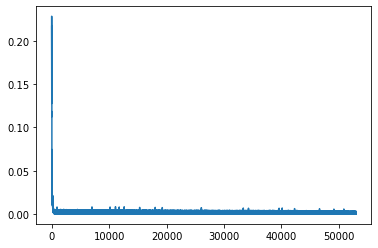

----------------------
시가->예측종가기준
벌어들인돈 : 310000원
정확도 : 0.494%
----------------------
전날예측종가->예측종가
벌어들인돈 : 86000원
정확도 : 0.467%


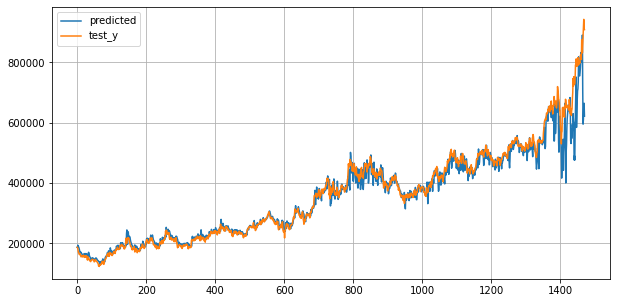

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  128
learning_r :  0.0005
epoch_size :  1000


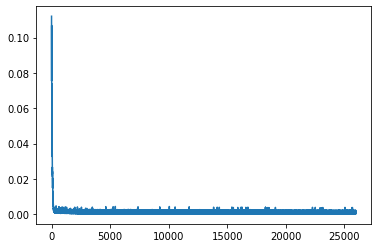

----------------------
시가->예측종가기준
벌어들인돈 : 722000원
정확도 : 0.508%
----------------------
전날예측종가->예측종가
벌어들인돈 : 380000원
정확도 : 0.475%


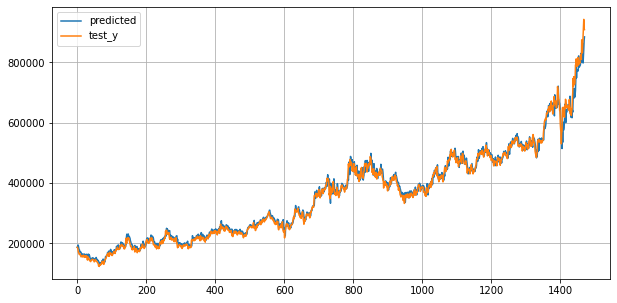

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  256
learning_r :  0.0005
epoch_size :  1000


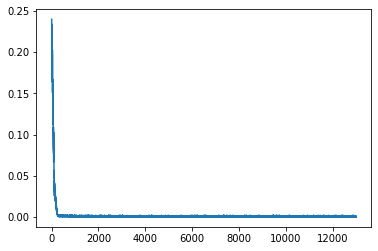

----------------------
시가->예측종가기준
벌어들인돈 : 816000원
정확도 : 0.501%
----------------------
전날예측종가->예측종가
벌어들인돈 : 221000원
정확도 : 0.462%


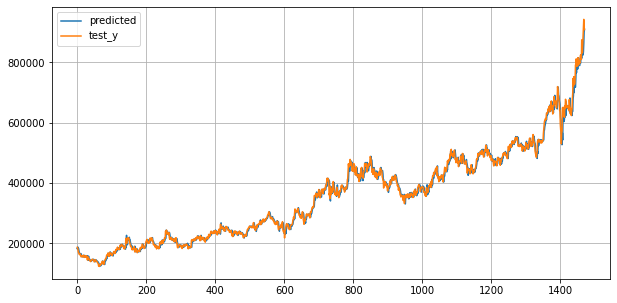

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  512
learning_r :  0.0005
epoch_size :  1000


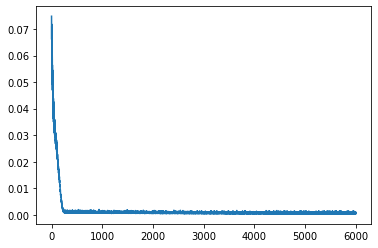

----------------------
시가->예측종가기준
벌어들인돈 : 641000원
정확도 : 0.496%
----------------------
전날예측종가->예측종가
벌어들인돈 : 214500원
정확도 : 0.476%


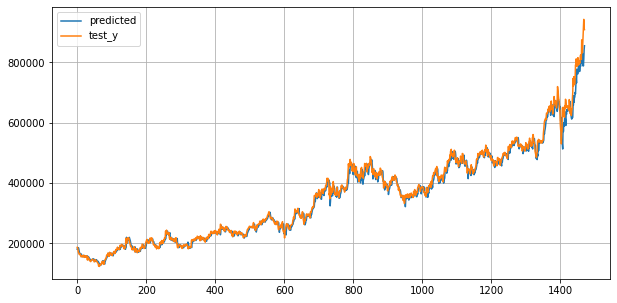

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  1024
learning_r :  0.0005
epoch_size :  1000


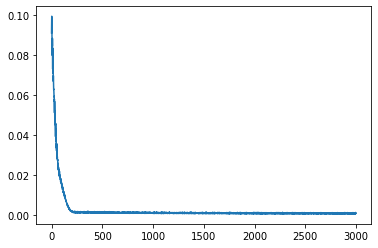

----------------------
시가->예측종가기준
벌어들인돈 : 1089500원
정확도 : 0.529%
----------------------
전날예측종가->예측종가
벌어들인돈 : 216500원
정확도 : 0.477%


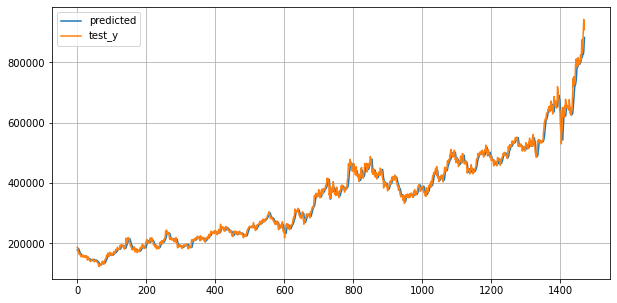

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  1
batch_size :  2048
learning_r :  0.0005
epoch_size :  1000


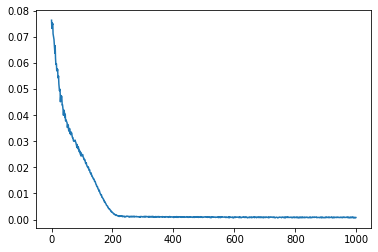

----------------------
시가->예측종가기준
벌어들인돈 : 1055500원
정확도 : 0.531%
----------------------
전날예측종가->예측종가
벌어들인돈 : 205000원
정확도 : 0.473%


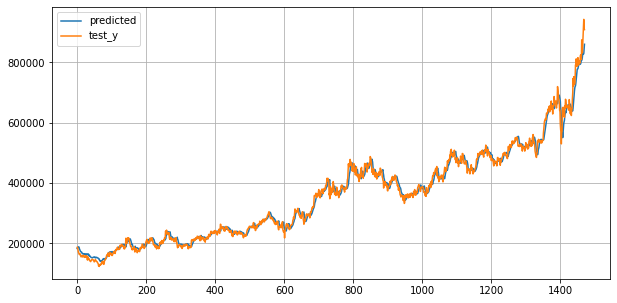

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  64
learning_r :  0.0005
epoch_size :  1000


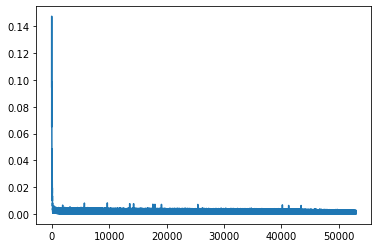

----------------------
시가->예측종가기준
벌어들인돈 : 372000원
정확도 : 0.493%
----------------------
전날예측종가->예측종가
벌어들인돈 : 159000원
정확도 : 0.462%


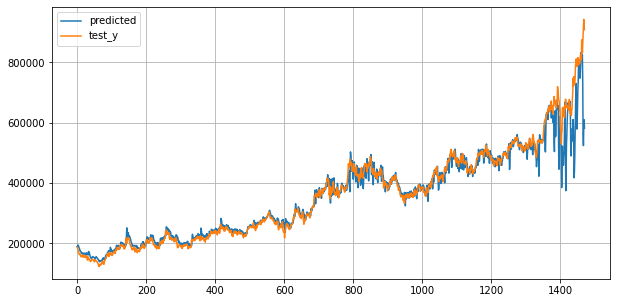

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  128
learning_r :  0.0005
epoch_size :  1000


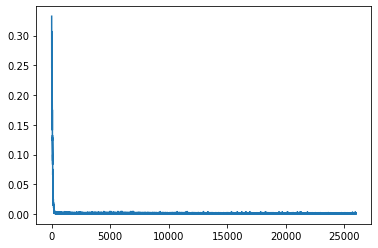

----------------------
시가->예측종가기준
벌어들인돈 : 377500원
정확도 : 0.487%
----------------------
전날예측종가->예측종가
벌어들인돈 : 349000원
정확도 : 0.473%


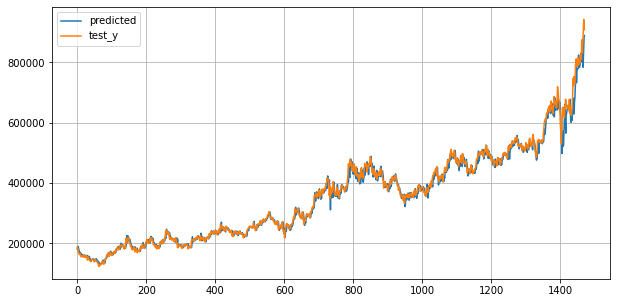

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  256
learning_r :  0.0005
epoch_size :  1000


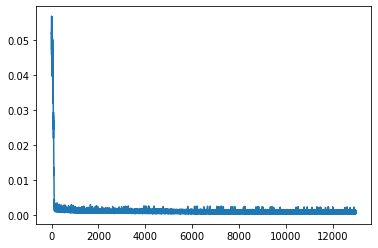

----------------------
시가->예측종가기준
벌어들인돈 : 729500원
정확도 : 0.495%
----------------------
전날예측종가->예측종가
벌어들인돈 : 283500원
정확도 : 0.471%


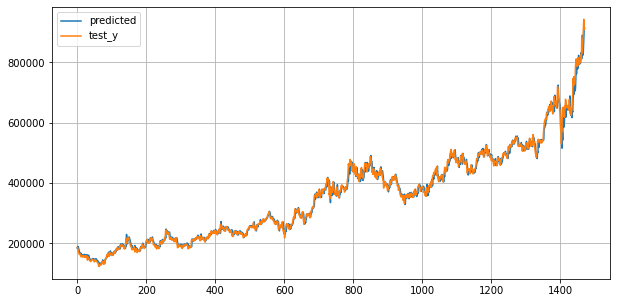

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  512
learning_r :  0.0005
epoch_size :  1000


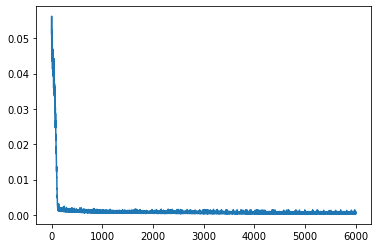

----------------------
시가->예측종가기준
벌어들인돈 : 799500원
정확도 : 0.509%
----------------------
전날예측종가->예측종가
벌어들인돈 : 307500원
정확도 : 0.471%


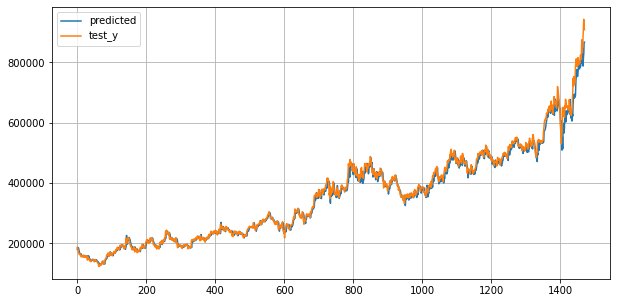

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  1024
learning_r :  0.0005
epoch_size :  1000


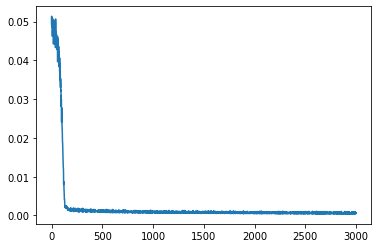

----------------------
시가->예측종가기준
벌어들인돈 : 1092000원
정확도 : 0.517%
----------------------
전날예측종가->예측종가
벌어들인돈 : 201500원
정확도 : 0.476%


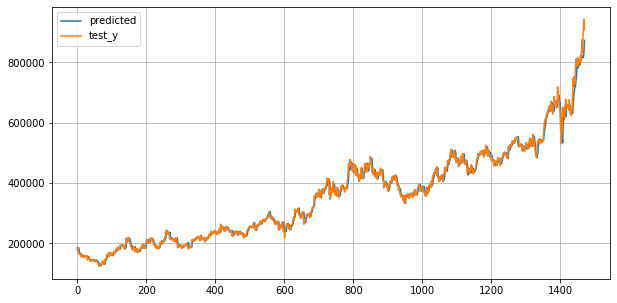

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  2
batch_size :  2048
learning_r :  0.0005
epoch_size :  1000


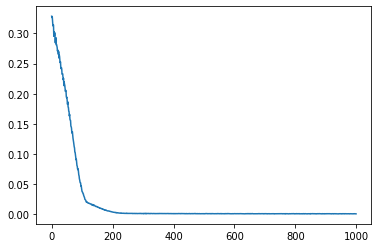

----------------------
시가->예측종가기준
벌어들인돈 : 887500원
정확도 : 0.508%
----------------------
전날예측종가->예측종가
벌어들인돈 : 156500원
정확도 : 0.465%


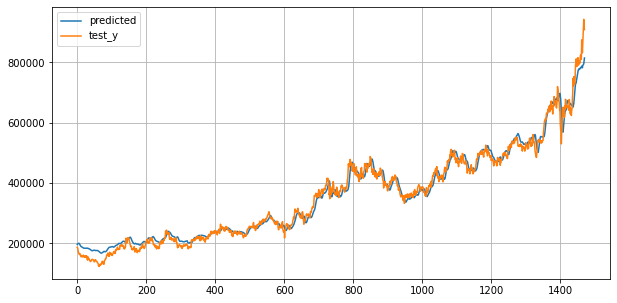

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  64
learning_r :  0.0005
epoch_size :  1000


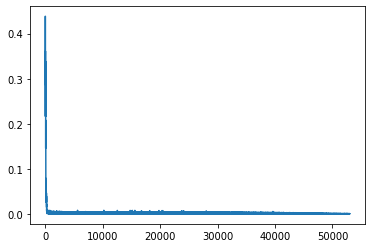

----------------------
시가->예측종가기준
벌어들인돈 : 797500원
정확도 : 0.513%
----------------------
전날예측종가->예측종가
벌어들인돈 : 326500원
정확도 : 0.478%


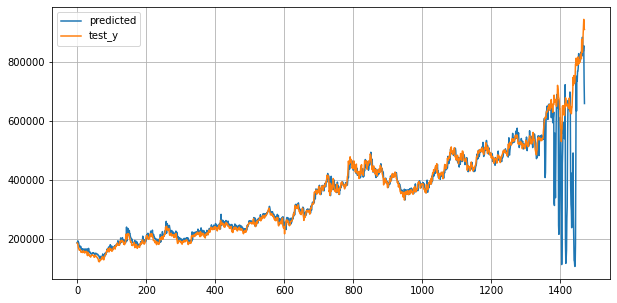

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  128
learning_r :  0.0005
epoch_size :  1000


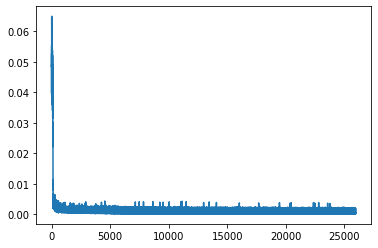

----------------------
시가->예측종가기준
벌어들인돈 : 325500원
정확도 : 0.481%
----------------------
전날예측종가->예측종가
벌어들인돈 : 270500원
정확도 : 0.471%


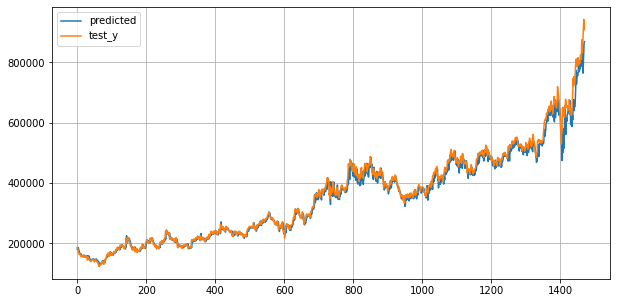

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  256
learning_r :  0.0005
epoch_size :  1000


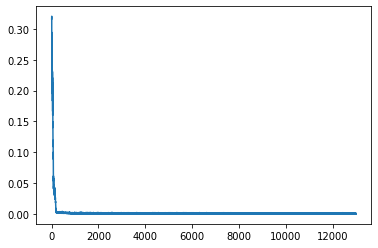

----------------------
시가->예측종가기준
벌어들인돈 : 486000원
정확도 : 0.495%
----------------------
전날예측종가->예측종가
벌어들인돈 : 285500원
정확도 : 0.469%


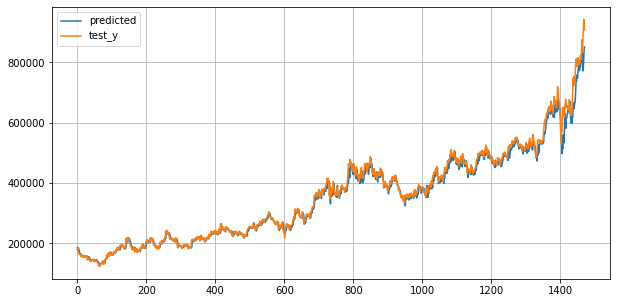

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  512
learning_r :  0.0005
epoch_size :  1000


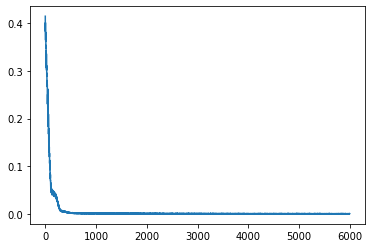

----------------------
시가->예측종가기준
벌어들인돈 : 600500원
정확도 : 0.497%
----------------------
전날예측종가->예측종가
벌어들인돈 : 346500원
정확도 : 0.466%


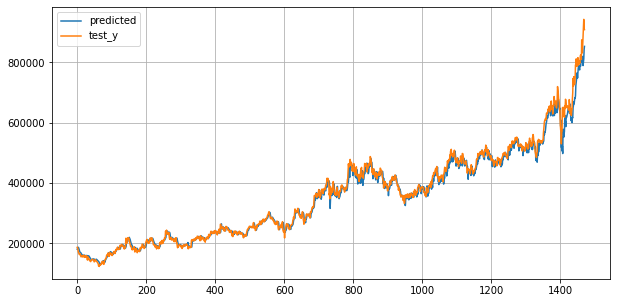

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  1024
learning_r :  0.0005
epoch_size :  1000


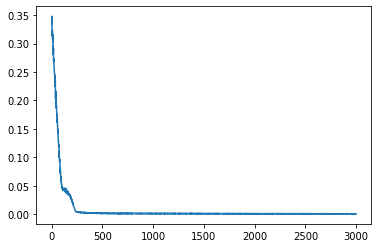

----------------------
시가->예측종가기준
벌어들인돈 : 653000원
정확도 : 0.508%
----------------------
전날예측종가->예측종가
벌어들인돈 : -31000원
정확도 : 0.460%


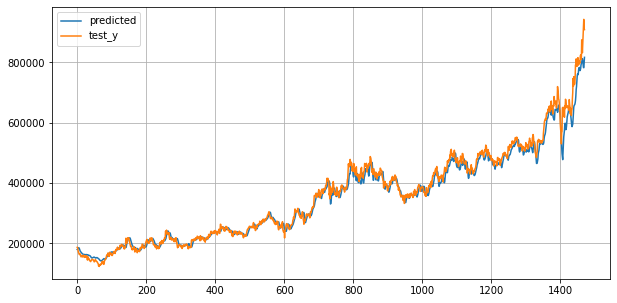

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  4
batch_size :  2048
learning_r :  0.0005
epoch_size :  1000


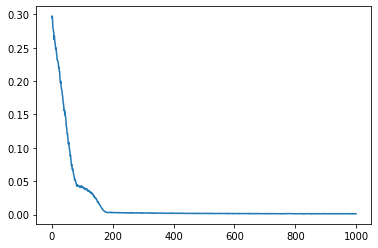

----------------------
시가->예측종가기준
벌어들인돈 : 1097500원
정확도 : 0.523%
----------------------
전날예측종가->예측종가
벌어들인돈 : 177000원
정확도 : 0.463%


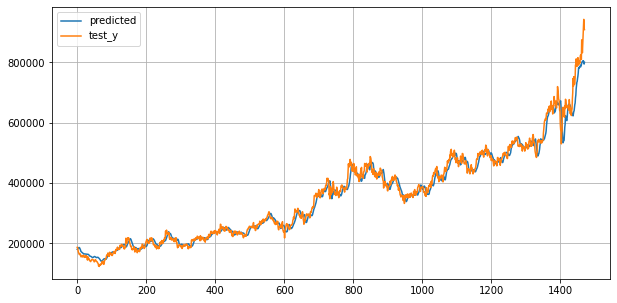

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  64
learning_r :  0.0005
epoch_size :  1000


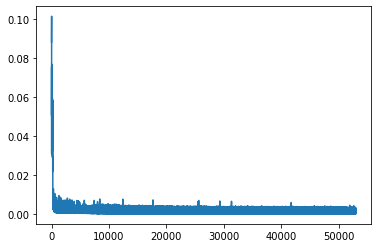

----------------------
시가->예측종가기준
벌어들인돈 : 820000원
정확도 : 0.498%
----------------------
전날예측종가->예측종가
벌어들인돈 : 82500원
정확도 : 0.461%


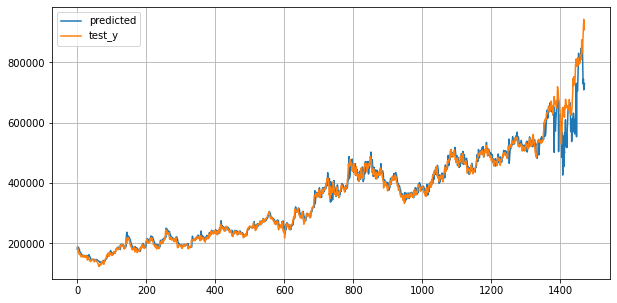

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  128
learning_r :  0.0005
epoch_size :  1000


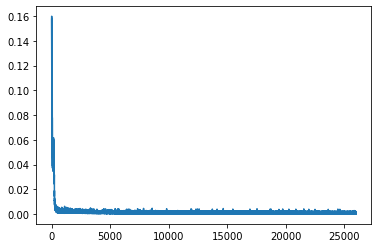

----------------------
시가->예측종가기준
벌어들인돈 : 784500원
정확도 : 0.497%
----------------------
전날예측종가->예측종가
벌어들인돈 : 184500원
정확도 : 0.462%


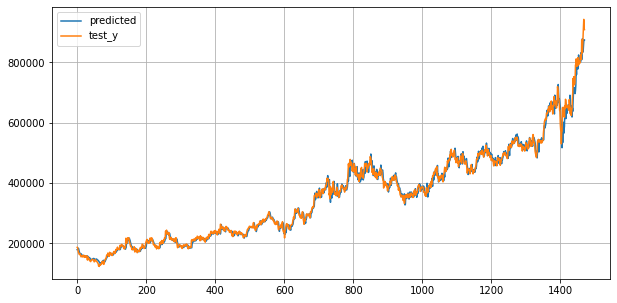

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  256
learning_r :  0.0005
epoch_size :  1000


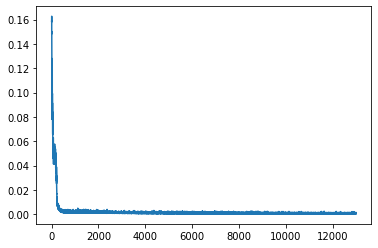

----------------------
시가->예측종가기준
벌어들인돈 : 605000원
정확도 : 0.502%
----------------------
전날예측종가->예측종가
벌어들인돈 : 228500원
정확도 : 0.459%


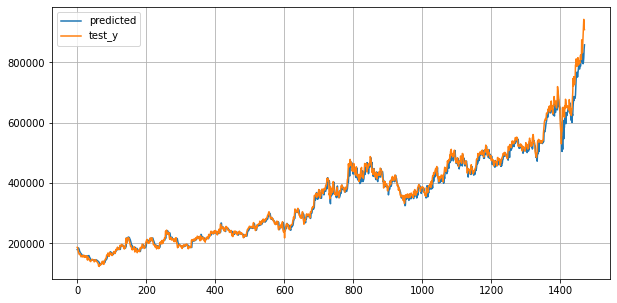

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  512
learning_r :  0.0005
epoch_size :  1000


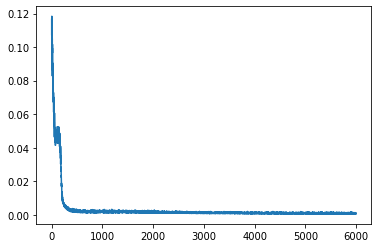

----------------------
시가->예측종가기준
벌어들인돈 : 614000원
정확도 : 0.507%
----------------------
전날예측종가->예측종가
벌어들인돈 : 353500원
정확도 : 0.488%


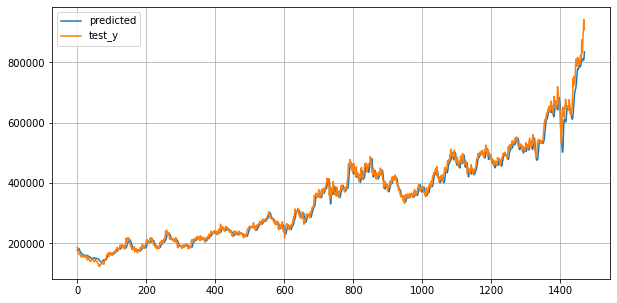

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  1024
learning_r :  0.0005
epoch_size :  1000


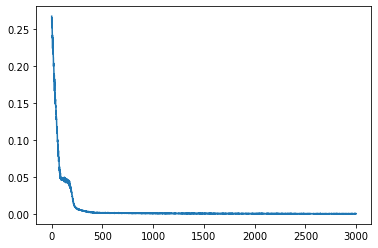

----------------------
시가->예측종가기준
벌어들인돈 : 794500원
정확도 : 0.514%
----------------------
전날예측종가->예측종가
벌어들인돈 : 328500원
정확도 : 0.487%


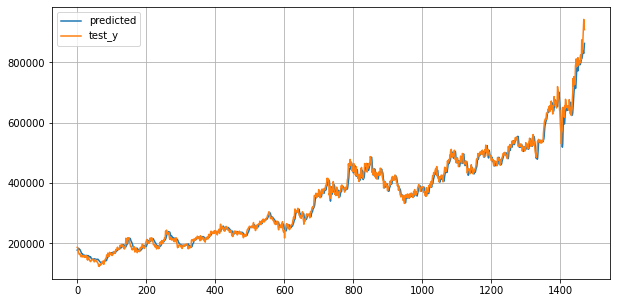

------------------------------------------------------------------------
Net(
  (rnn): LSTM(6, 10, num_layers=8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
----------------------
layers_num :  8
batch_size :  2048
learning_r :  0.0005
epoch_size :  1000


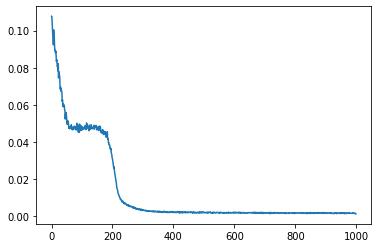

----------------------
시가->예측종가기준
벌어들인돈 : 1100000원
정확도 : 0.515%
----------------------
전날예측종가->예측종가
벌어들인돈 : 398000원
정확도 : 0.463%


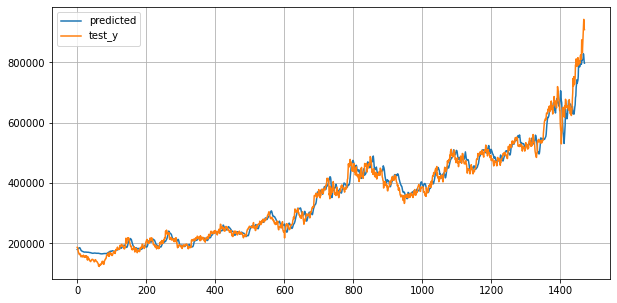

In [35]:
for layers in [1,2,4,8]:
    for batch_size in [64, 128, 256, 512, 1024, 2048]:
        train_loader, test_loader= load(batch_size=batch_size)
        model = Net(data_dim, hidden_dim, output_dim, layers).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_func = torch.nn.MSELoss()
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1, patience=1, mode='min')
        loss_arr = train_model()
        predicted, test_x, test_y = test_model()
        calc_pred_y, calc_test_y, calc_test_x = reverse_minmax()

        show_train_status()
        day = len(calc_pred_y)
        eval_open_to_predict_close(day)
        eval_endPredict_to_predict_close(day)
        show_test_graph(day)